# Anomaly Detection: Moving Z-Score and Bayesian Changepoints Model

## Introductory Remarks

Anomalies are data points that are different from other observations in some way, typically measured against a model fit to the data. On the contrary with the ordinary descriptive statistics, we are interested here to found where these anomalous data points exist and not exclude them as outliers.

We assume the anomaly detection task is unsupervised, i.e. we don’t have training data with points labeled as anomalous. Each data point passed to an anomaly detection model is given a score indicating how different the point is relative to the rest of the dataset. The calculation of this score varies between models, but a higher score always indicates a point is more anomalous. Often a threshold is chosen to make a final classification of each point as typical or anomalous; this post-processing step is left to the user.

The **GraphLab Create (GLC) Anomaly Detection toolkit** currently includes three models for two different data contexts: 

* **Local Outlier Factor**, for detecting outliers in multivariate data that are assumed to be independently and identically distributed,
* **Moving Z-score**, for scoring outliers in a univariate, sequential dataset, typically a time series, and
* **Bayesian Changepoints** for identifying changes in the mean or variance of a sequential series.

In this short note, we demonstrate how the **Moving Z-Score** and **Bayesian Changepoints** models can be used to *reveal anomalies* in a *time series* object. As an example we are going to use the *"Crude Oil Prices: Brent - Europe"* time series, *[`FRED-DCOILBRENTEU`](https://www.quandl.com/data/FRED/DCOILBRENTEU-Crude-Oil-Prices-Brent-Europe)*, as it is currently provided by the *[Quandl](https://www.quandl.com/)* database of finance and economic data and the *[Federal Reserve Bank of St. Luis](https://research.stlouisfed.org/fred2/series/DCOILBRENTEU)*. This times series covers the daily closing prices of Crude Oil Brent - Europe (Dollars per Barrel, Not Seasonally Adjusted) starting from May 1987 to May 2016. It follows a pretty volatile behavior across the years, and we hope to find out where the most anomalous spot values are. For notes and definitions, please see the corresponding [US Energy Information Agency (eia), Explanatory Notes](http://www.eia.gov/dnav/pet/TblDefs/pet_pri_spt_tbldef2.asp).

## The GLC Moving Z-Score Model

In a first step of our analysis, we are going to use the **GLC Moving Z-Score** implementation. This unsupervised learning model fits a moving average to a univariate time series and identifying that way points that are far from the fitted curve. The **`MovingZScoreModel`** works with either **`TimeSeries`** or **`SFrame`** inputs. A *uniform sampling rate* is *assumed* and the *data window* must be *defined* in terms of *number of observations*.

The **moving Z-score** for a data point $x_{t}$ is simply the value of $x_{t}$ standardized by subtracting the moving mean just prior to time $t$ and dividing by the moving standard deviation which is calculated for the same time interval. In particular, assuming that $w$ stands for the **`window_size`** in terms of the number of observations the **moving Z-score** is defined as:

\begin{equation*}
z(x_{t}) = \frac{x_{t}-\bar{x}_{t}}{s_{t}},
\end{equation*}

where the moving average is:

\begin{equation*}
\bar{x}_{t} = (1/w)\,\sum_{i=t-w}^{t-1}x_{i},
\end{equation*}

and the standard deviation for the same time interval:

\begin{equation*}
s_{t} = \sqrt{(1/w)\,\sum_{i=t-w}^{t-1}(x_{i}-\bar{x}_{t})^{2}}. 
\end{equation*}

**Notes:**

1. The **moving Z-score** at points within the **`window_size`** observations of the beginning of a series are not defined, because there are insufficient points to compute the moving average and moving standard deviation. This is represented by missing values.

2. **Missing values** in the input dataset are assigned missing values (**‘None’**) for their anomaly scores as well.

3. If there is no variation in the values preceding a given observation, the **moving Z-score** can be infinite or undefined. If the given observation is equal to the moving average, the anomaly score is coded as **`'nan'`**; if the observation is not equal to the moving average, the anomaly score is **`'inf'`**.


## The GLC Bayesian Changepoints Model

As a next step of our analysis we are going to use the **GLC Bayesian Changepoints** model and compare the results of these two methods. The Bayesian Changepoints implementation scores changepoint probability in a univariate sequential dataset, often a time series. Changepoints are abrupt changes in the mean or variance of a time series. For instance, during an economic recession, stock values might suddenly drop to a very low value. The time at which the stock value dropped is called a changepoint.

The Bayesian Changepoints model is an implementation of the *[Bayesian Online Changepoint Detection algorithm](https://hips.seas.harvard.edu/files/adams-changepoint-tr-2007.pdf)* developed by Ryan Adams and David MacKay. This algorithm computes a probability distribution over the possible *run lengths* at each point in the data, where *run length* refers to the number of observations since the last changepoint. When the probability of a 0-length run spikes, there is most likely a change point at the current data point.

More specifically, the **algorithm follows** the **procedure** below:

**Step 1:** Observe new datum $x_{t}$ and evaluate the likelihood of seeing this value for each possible run length. This is a probability vector, with an element for all possible run lengths. A Gaussian distribution between each pair of changepoints is assumed.

\begin{equation*}
L(r)= P(x|x_{r})
\end{equation*}

**Step 2:**  For each possible run length, $r>0$,  at current time $t$, calculate the probability of growth. **`expected_runlength`** is a parameter describing the a-priori best guess of run length. The larger **`expected_runlength`** is, the stronger the evidence must be in the data to support a high changepoint probability.

\begin{equation*}
P_{t}(runlength\equiv r) = P_{t-1}(runlength\equiv r-1)\ast L(r)\ast \left(1-\frac{1}{{expected\_runlength}}\right)
\end{equation*}

**Step 3:** Calculate probability of change, or $r=0$.

\begin{equation*}
P_{t}(runlength\equiv 0)= \sum_{r_{prev}}\left[P_{t−1}(runlength\equiv r_{prev})\ast L(0)\ast \left(\frac{1}{expected\_runlength}\right)\right]
\end{equation*}

**Step 4:** Normalize the probability. For all run length probabilities at time $t$, divide by the sum of all run length probabilities.

\begin{equation*}
P_{t}(runlength\equiv r_{i})=\frac{P_{t}(runlength\equiv r_{i})}{\sum_{r}P_{t}(runlength\equiv r)}
\end{equation*}

For each incoming point, this process is repeated. 

This per-point update is why the method is considered an *online learning algorithm*.

As described, the algorithm scores each point $x_{t}$ immediately, but if the user can afford to wait several observations, it is often more accurate to assign lagged changepoint scores. The number of observations to wait before scoring a point is set with the **`lag`** parameter.

## Libraries and Necessary Data Transformation

First we fire up **GraphLab Create**, all the other necessary libraries for our study and load the *`FRED/DCOILBRENTEU`* data set in an **SFrame**.

In [1]:
import graphlab as gl
import matplotlib.pyplot as plt

[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1466491373.log
INFO:graphlab.cython.cy_server:GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1466491373.log


This non-commercial license of GraphLab Create is assigned to tgrammat@gmail.com and will expire on September 21, 2016. For commercial licensing options, visit https://dato.com/buy/.


In [2]:
fred_dcoilbrenteu = gl.SFrame.read_csv('./FRED-DCOILBRENTEU.csv')

Finished parsing file /home/theod/Documents/ML_Home/12.DatoPy/01.R.Anomaly_Detection/FRED-DCOILBRENTEU.csv

Parsing completed. Parsed 100 lines in 0.472685 secs.

Finished parsing file /home/theod/Documents/ML_Home/12.DatoPy/01.R.Anomaly_Detection/FRED-DCOILBRENTEU.csv

Parsing completed. Parsed 7345 lines in 0.258323 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [3]:
fred_dcoilbrenteu

DATE,VALUE
2016-05-02,45.82
2016-04-29,45.64
2016-04-28,45.6
2016-04-27,44.17
2016-04-26,43.94
2016-04-25,42.97
2016-04-22,43.97
2016-04-21,43.48
2016-04-20,43.09
2016-04-19,43.02


Next we transform the **`DATE`** column in an appropriate timestamp format, and the **`fred_dcoilbrenteu` SFrame** in a **TimeSeries object**.

In [4]:
import time
import dateutil

def _unix_timestamp_to_datetime(x):
    import datetime
    import pytz
    return dateutil.parser.parse(x)

fred_dcoilbrenteu['DATE'] = fred_dcoilbrenteu['DATE'].apply(_unix_timestamp_to_datetime)
fred_dcoilbrenteu = gl.TimeSeries(fred_dcoilbrenteu, index='DATE')
fred_dcoilbrenteu

DATE,VALUE
1987-05-20 00:00:00,18.63
1987-05-21 00:00:00,18.45
1987-05-22 00:00:00,18.55
1987-05-25 00:00:00,18.6
1987-05-26 00:00:00,18.63
1987-05-27 00:00:00,18.6
1987-05-28 00:00:00,18.6
1987-05-29 00:00:00,18.58
1987-06-01 00:00:00,18.65
1987-06-02 00:00:00,18.68


We can plot the **`fred_dcoilbrenteu`** time series set as follows.

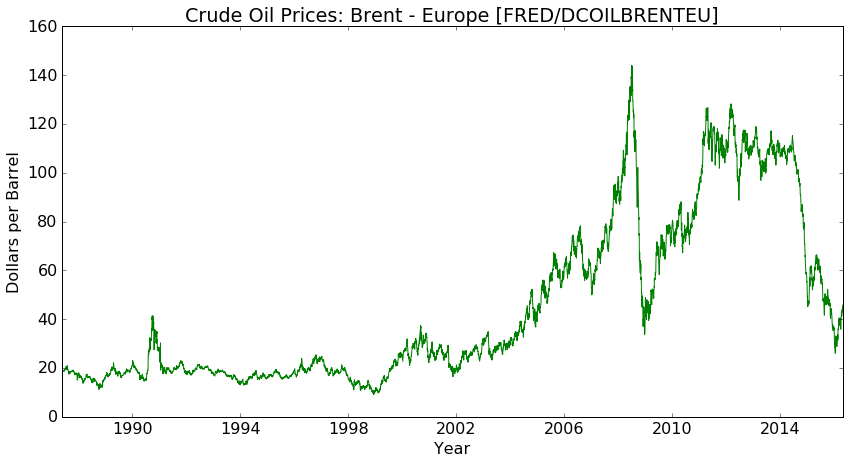

In [6]:
%matplotlib inline

def plot_time_series(timestamp, values, title, **kwargs):
    plt.rcParams['figure.figsize'] = 14, 7
    plt.plot_date(timestamp, values, fmt='g-', tz='utc', **kwargs)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Dollars per Barrel')
    plt.rcParams.update({'font.size': 16})
    
plot_time_series(fred_dcoilbrenteu['DATE'], fred_dcoilbrenteu['VALUE'],\
                 'Crude Oil Prices: Brent - Europe [FRED/DCOILBRENTEU]')

## Training a Moving Z-Score Model

In this section we train a **Moving Z-Score** model to reveal where any anomalies exist in the **`fred_dcoilbrenteu`** time series.

In [7]:
window_size = 252 # average trading days per year 
model_moving_zscore =gl.anomaly_detection.moving_zscore.create(fred_dcoilbrenteu, 
                                                               window_size, feature='VALUE')

The primary output of the **Moving Z-score** model is the **`scores`** field. This **TimeSeries** object contains:

* **`row id/time`**: ID of the corresponding row in the input dataset. Here the dataset is a **TimeSeries** object and the model returns the **`DATE`** timestamp. If it was an **SFrame**, this column would be filled with the *row numbers* of the input data.
* **`anomaly score`**: absolute value of the moving Z-score. A score of 0 indicates that the value is identical to the moving average. The higher the score, the more likely a point is to be an anomaly.
* **`VALUE`**: the recorded value of Dollars per Barrel of "Crude Oil Brent - Europe".
* **`model update time`**: time that the model was updated. This is particularly useful for model updating.

In [8]:
scores = model_moving_zscore.scores.to_sframe()
scores.print_rows(num_rows=10, max_row_width=100)

+---------------------+---------------+-------+----------------+----------------------------+
|         DATE        | anomaly_score | VALUE | moving_average |     model_update_time      |
+---------------------+---------------+-------+----------------+----------------------------+
| 1987-05-20 00:00:00 |      None     | 18.63 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-21 00:00:00 |      None     | 18.45 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-22 00:00:00 |      None     | 18.55 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-25 00:00:00 |      None     |  18.6 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-26 00:00:00 |      None     | 18.63 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-27 00:00:00 |      None     |  18.6 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-28 00:00:00 |      None     |  18.6 |      None      | 2016-06-21 09:52:23.887247 |
| 1987-05-29 00:00:00 |      None     | 18.58 |      None   

In [9]:
scores[252-10:252+10].print_rows(num_rows=60, max_row_width=100)

+---------------------+----------------+-------+----------------+----------------------------+
|         DATE        | anomaly_score  | VALUE | moving_average |     model_update_time      |
+---------------------+----------------+-------+----------------+----------------------------+
| 1988-05-03 00:00:00 |      None      | 16.08 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-04 00:00:00 |      None      | 16.15 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-05 00:00:00 |      None      | 16.15 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-06 00:00:00 |      None      | 16.45 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-09 00:00:00 |      None      |  16.5 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-10 00:00:00 |      None      | 16.38 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-11 00:00:00 |      None      | 16.48 |      None      | 2016-06-21 09:52:23.887247 |
| 1988-05-12 00:00:00 |      None      |  16.4 |  

Of course, the first 252 rows of the scores output don't have a **moving average** or **Z-score**. This is because the moving window does not have sufficient data for those observations. 

To reveal the 30, lets say, more anomalous data points we can sort the **`scores`** SFrame as follows.

In [10]:
scores.sort('anomaly_score', ascending=False).print_rows(num_rows=30, max_row_width=100)

+---------------------+---------------+-------+----------------+----------------------------+
|         DATE        | anomaly_score | VALUE | moving_average |     model_update_time      |
+---------------------+---------------+-------+----------------+----------------------------+
| 1990-08-23 00:00:00 | 4.94908744385 | 32.35 | 18.6811111111  | 2016-06-21 09:52:23.887247 |
| 1990-08-06 00:00:00 | 4.90849694957 | 27.28 | 18.1406349206  | 2016-06-21 09:52:23.887247 |
| 1990-08-07 00:00:00 | 4.71149150733 | 27.35 | 18.1836111111  | 2016-06-21 09:52:23.887247 |
| 1996-04-11 00:00:00 | 4.53804346471 |  23.9 | 17.5057539683  | 2016-06-21 09:52:23.887247 |
| 1990-09-24 00:00:00 | 4.50692667542 | 40.75 | 19.9052777778  | 2016-06-21 09:52:23.887247 |
| 1990-08-24 00:00:00 | 4.46580793477 | 31.65 | 18.7421031746  | 2016-06-21 09:52:23.887247 |
| 1990-08-22 00:00:00 | 4.44080480957 | 30.45 | 18.6275396825  | 2016-06-21 09:52:23.887247 |
| 2014-10-15 00:00:00 | 4.19616613166 | 84.02 | 106.43111111

Of cource, a lot more anomalous observations may exist in the **`fred_dcoilbrenteu`** time series. A good way to make a final decision on that, is to look at the approximate distribution of the anomaly scores with the **`SArray.sketch_summary()`** tool, then get a **threshold** for the **anomaly score** with the **sketch summary's quantile** method. Here we declare the top 1&#37; of the data to be anomalies, characterizing that way 71 data points as "anomalous".

In [11]:
sketch = scores['anomaly_score'].sketch_summary()
threshold = sketch.quantile(0.99)
anomalies = scores[scores['anomaly_score'] > threshold]
anomalies.print_rows(num_rows=30, max_row_width=100)

+---------------------+---------------+-------+----------------+----------------------------+
|         DATE        | anomaly_score | VALUE | moving_average |     model_update_time      |
+---------------------+---------------+-------+----------------+----------------------------+
| 1990-01-03 00:00:00 | 3.58789470296 | 22.65 | 18.2605555556  | 2016-06-21 09:52:23.887247 |
| 1990-01-04 00:00:00 | 3.37071772998 |  22.5 | 18.2835714286  | 2016-06-21 09:52:23.887247 |
| 1990-01-05 00:00:00 | 3.78091207137 | 23.13 | 18.3053968254  | 2016-06-21 09:52:23.887247 |
| 1990-08-06 00:00:00 | 4.90849694957 | 27.28 | 18.1406349206  | 2016-06-21 09:52:23.887247 |
| 1990-08-07 00:00:00 | 4.71149150733 | 27.35 | 18.1836111111  | 2016-06-21 09:52:23.887247 |
| 1990-08-08 00:00:00 | 3.41562168654 | 25.15 | 18.2249603175  | 2016-06-21 09:52:23.887247 |
| 1990-08-09 00:00:00 | 3.68825352627 |  25.9 | 18.2573015873  | 2016-06-21 09:52:23.887247 |
| 1990-08-10 00:00:00 | 3.76751744623 |  26.3 | 18.293214285

In the figure below, we plot the original **`FRED/DCOILBRENTEU`** time series of *"Dollars per Barrel of Crude Oil Brent - Europe"*, its **Moving Average** across the years, and the data points that we found to be **anomalous**.

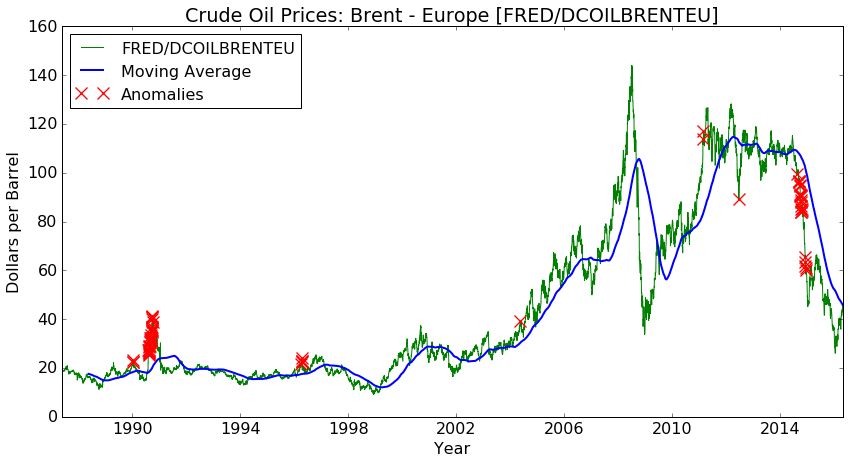

In [12]:
%matplotlib inline

plot_time_series(fred_dcoilbrenteu['DATE'], fred_dcoilbrenteu['VALUE'],\
                 'Crude Oil Prices: Brent - Europe [FRED/DCOILBRENTEU]', label='FRED/DCOILBRENTEU')
plt.plot_date(scores['DATE'], scores['moving_average'], fmt='b-', tz='utc', lw=2, label='Moving Average')
plt.plot(anomalies['DATE'], anomalies['VALUE'], 'rx', markersize=12, markeredgewidth=1.3, label='Anomalies')
plt.legend(loc='upper left', prop={'size': 16})
plt.show()

## Training a Bayesian Changepoints Model

In this second part of our analysis we train a **Bayesian Changepoints** model to reveal where any anomalies exist in the **`fred_dcoilbrenteu`** time series.

In [13]:
model_bayesian_changepoints = gl.anomaly_detection.bayesian_changepoints.\
create(fred_dcoilbrenteu,
       feature='VALUE',
       # avg trading days per year
       expected_runlength = 252,
       # avg trading days per fiscal quarter
       lag=63)

The primary output of the **Moving Z-score** model is the **`scores`** field. This **TimeSeries** object contains:

* **`row id/time`**: ID of the corresponding row in the input dataset. Here the dataset is a **TimeSeries** object and the model returns the **`DATE`** timestamp. If it was an **SFrame**, this column would be filled with the *row numbers* of the input data.
* **`changepoint_score`**: The probability that the given point is a changepoint. This value is in a range between 0 and 1.
* **`VALUE`**: the recorded value of Dollars per Barrel of "Crude Oil Brent - Europe".
* **`model update time`**: time that the model was updated. This is particularly useful for model updating.

In [14]:
scores2 = model_bayesian_changepoints.scores.to_sframe()
scores2.print_rows(num_rows=10, max_row_width=100)

+---------------------+-------------------+-------+----------------------------+
|         DATE        | changepoint_score | VALUE |     model_update_time      |
+---------------------+-------------------+-------+----------------------------+
| 1987-05-20 00:00:00 | 1.29686499738e-20 | 18.63 | 2016-06-21 09:54:08.274432 |
| 1987-05-21 00:00:00 | 2.74120099668e-20 | 18.45 | 2016-06-21 09:54:08.274432 |
| 1987-05-22 00:00:00 | 7.22591567726e-20 | 18.55 | 2016-06-21 09:54:08.274432 |
| 1987-05-25 00:00:00 | 2.38425982431e-19 |  18.6 | 2016-06-21 09:54:08.274432 |
| 1987-05-26 00:00:00 | 7.65491442957e-19 | 18.63 | 2016-06-21 09:54:08.274432 |
| 1987-05-27 00:00:00 | 8.12765511891e-19 |  18.6 | 2016-06-21 09:54:08.274432 |
| 1987-05-28 00:00:00 | 1.97680271459e-18 |  18.6 | 2016-06-21 09:54:08.274432 |
| 1987-05-29 00:00:00 | 6.92500314492e-18 | 18.58 | 2016-06-21 09:54:08.274432 |
| 1987-06-01 00:00:00 | 2.20387527272e-17 | 18.65 | 2016-06-21 09:54:08.274432 |
| 1987-06-02 00:00:00 | 1.32

To reveal the 30, lets say, more anomalous data points we can sort the **`scores`** SFrame as follows.

In [15]:
scores2.sort('changepoint_score', ascending=False).print_rows(num_rows=30, max_row_width=100)

+---------------------+-------------------+-------+----------------------------+
|         DATE        | changepoint_score | VALUE |     model_update_time      |
+---------------------+-------------------+-------+----------------------------+
| 1995-06-19 00:00:00 |   0.90101518149   | 16.93 | 2016-06-21 09:54:08.274432 |
| 1993-06-11 00:00:00 |   0.597158089704  | 17.63 | 2016-06-21 09:54:08.274432 |
| 1999-11-09 00:00:00 |   0.507500739218  | 24.44 | 2016-06-21 09:54:08.274432 |
| 1996-09-02 00:00:00 |   0.445819040465  | 22.23 | 2016-06-21 09:54:08.274432 |
| 2002-12-16 00:00:00 |   0.433560636239  | 28.73 | 2016-06-21 09:54:08.274432 |
| 2000-12-06 00:00:00 |   0.401576517802  | 27.47 | 2016-06-21 09:54:08.274432 |
| 1998-06-09 00:00:00 |   0.392100642229  | 12.76 | 2016-06-21 09:54:08.274432 |
| 2000-12-05 00:00:00 |   0.388410685527  | 28.88 | 2016-06-21 09:54:08.274432 |
| 2000-05-08 00:00:00 |   0.387010858837  | 26.03 | 2016-06-21 09:54:08.274432 |
| 2015-08-03 00:00:00 |   0.

One interesting thing is that if you look at the tail of scores, you will see a handful of missing values. These data points have insufficient data after them to compute lagged changepoint scores. The number of missing values in the tail of the dataset can be reduced by equally reducing the **`lag`** parameter in our learning model. However, the returned results will be less accurate. Alternatively, one can choose to update the model with new data.

In [16]:
scores2.tail(80).print_rows(num_rows=80, max_row_width=100)

+---------------------+-------------------+-------+----------------------------+
|         DATE        | changepoint_score | VALUE |     model_update_time      |
+---------------------+-------------------+-------+----------------------------+
| 2016-01-08 00:00:00 |  3.1848228973e-07 | 31.67 | 2016-06-21 09:54:08.274432 |
| 2016-01-11 00:00:00 | 1.75562959897e-07 | 30.14 | 2016-06-21 09:54:08.274432 |
| 2016-01-12 00:00:00 | 8.45743413791e-08 | 29.14 | 2016-06-21 09:54:08.274432 |
| 2016-01-13 00:00:00 |  3.5737942485e-08 | 28.58 | 2016-06-21 09:54:08.274432 |
| 2016-01-14 00:00:00 |  1.4244636465e-08 | 28.84 | 2016-06-21 09:54:08.274432 |
| 2016-01-15 00:00:00 | 6.62431079546e-09 |  28.8 | 2016-06-21 09:54:08.274432 |
| 2016-01-18 00:00:00 | 3.36583267973e-09 | 27.36 | 2016-06-21 09:54:08.274432 |
| 2016-01-19 00:00:00 | 1.88146995405e-09 | 27.36 | 2016-06-21 09:54:08.274432 |
| 2016-01-20 00:00:00 |  1.3459841952e-09 | 26.01 | 2016-06-21 09:54:08.274432 |
| 2016-01-21 00:00:00 | 1.59

Of cource, a lot more anomalous observations may exist in the **`fred_dcoilbrenteu`** time series. A good way to make a final decision on that, is to look at the approximate distribution of the changepoint scores with the **`SArray.sketch_summary()`** tool, then get a **threshold** for the **changepoint score** with the **sketch summary's quantile** method. Again, we declare the top 1&#37; of the data to be anomalies, characterizing that way 75 data points as "anomalous".

In [17]:
sketch2 = scores2['changepoint_score'].sketch_summary()
threshold2 = sketch2.quantile(0.99)
changepoints = scores2[scores2['changepoint_score'] > threshold2]
changepoints.print_rows(num_rows=105, max_row_width=100)

+---------------------+-------------------+--------+----------------------------+
|         DATE        | changepoint_score | VALUE  |     model_update_time      |
+---------------------+-------------------+--------+----------------------------+
| 1988-06-10 00:00:00 |   0.266631063592  | 15.85  | 2016-06-21 09:54:08.274432 |
| 1988-06-13 00:00:00 |   0.304947019691  | 15.53  | 2016-06-21 09:54:08.274432 |
| 1988-09-01 00:00:00 |   0.204701731073  | 14.15  | 2016-06-21 09:54:08.274432 |
| 1988-09-02 00:00:00 |   0.28354659943   |  14.0  | 2016-06-21 09:54:08.274432 |
| 1988-09-05 00:00:00 |   0.251226755215  | 13.68  | 2016-06-21 09:54:08.274432 |
| 1990-09-05 00:00:00 |   0.203866663955  | 31.23  | 2016-06-21 09:54:08.274432 |
| 1990-09-06 00:00:00 |   0.160739419458  | 32.15  | 2016-06-21 09:54:08.274432 |
| 1992-06-30 00:00:00 |   0.193569230058  |  20.6  | 2016-06-21 09:54:08.274432 |
| 1992-07-01 00:00:00 |   0.264558117223  | 20.25  | 2016-06-21 09:54:08.274432 |
| 1992-07-06 00:

In the figure below, we plot the original **`FRED/DCOILBRENTEU`** time series of *"Dollars per Barrel of Crude Oil Brent - Europe"*, its **Moving Average** across the years, and the data points that we found to be **anomalous** with both the **Moving Z-Score** and the **Bayesian Changepoint** model.

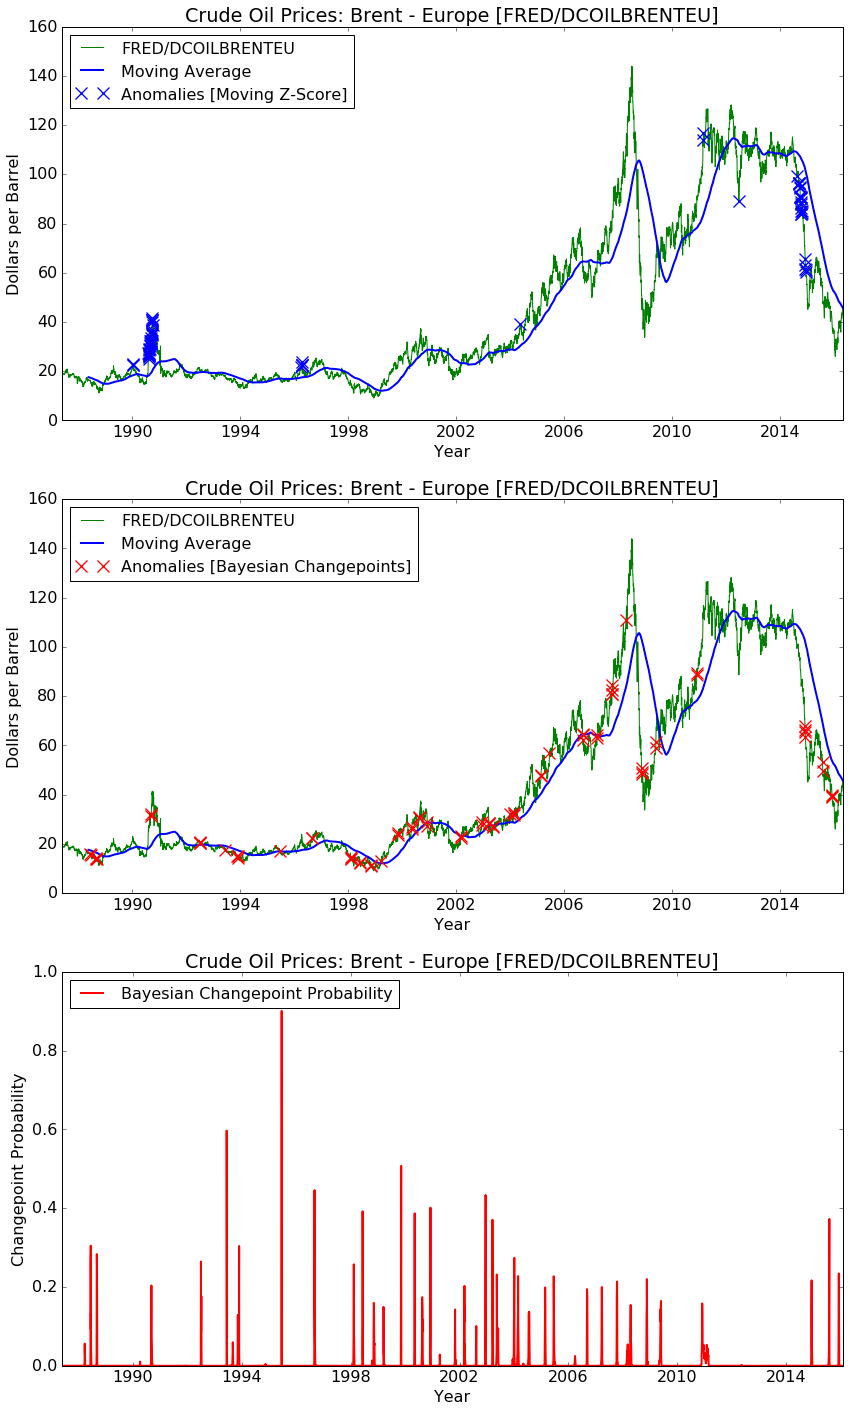

In [18]:
%matplotlib inline

plt.rcParams['figure.figsize'] = 14, 24
plt.figure(1)

plt.subplot(3,1,1)
plt.plot_date(fred_dcoilbrenteu['DATE'], fred_dcoilbrenteu['VALUE'],\
              fmt='g-', tz='utc', label='FRED/DCOILBRENTEU')
plt.plot_date(scores['DATE'], scores['moving_average'],\
              fmt='b-', tz='utc', lw=2, label='Moving Average')
plt.xlabel('Year')
plt.ylabel('Dollars per Barrel')
plt.title('Crude Oil Prices: Brent - Europe [FRED/DCOILBRENTEU]')
plt.rcParams.update({'font.size': 16})
plt.plot(anomalies['DATE'], anomalies['VALUE'],\
         'bx', markersize=12, markeredgewidth=1.3, label='Anomalies [Moving Z-Score]')
plt.legend(loc='upper left', prop={'size': 16})

plt.subplot(3,1,2)
plt.plot_date(fred_dcoilbrenteu['DATE'], fred_dcoilbrenteu['VALUE'],\
              fmt='g-', tz='utc', label='FRED/DCOILBRENTEU')
plt.plot_date(scores['DATE'], scores['moving_average'],\
              fmt='b-', tz='utc', lw=2, label='Moving Average')
plt.xlabel('Year')
plt.ylabel('Dollars per Barrel')
plt.title('Crude Oil Prices: Brent - Europe [FRED/DCOILBRENTEU]')
plt.rcParams.update({'font.size': 16})
plt.plot(changepoints['DATE'], changepoints['VALUE'],\
         'rx', markersize=12, markeredgewidth=1.3, label='Anomalies [Bayesian Changepoints]')
plt.legend(loc='upper left', prop={'size': 16})

plt.subplot(3,1,3)
plt.plot_date(scores2['DATE'], scores2['changepoint_score'],\
              fmt='r-', tz='utc', lw=2, label='Bayesian Changepoint Probability')
plt.rcParams.update({'font.size': 16})
plt.xlabel('Year')
plt.ylabel('Changepoint Probability')
plt.title('Crude Oil Prices: Brent - Europe [FRED/DCOILBRENTEU]')
plt.legend(loc='upper left', prop={'size': 16})

plt.show()

Interestingly enough, the **Bayesian Changepoint** model revealed some new anomalous points which were obviously missed by the **Moving Z-Score** algorithm. More specifically, new anomalous data points observed during the periods 1998-2000 and 2006-2010. More importantly, the great depreciation of Crude Oil Prices (Brent-Europe) during the recent great recession (2007-2008) is now characterized an an additional anomalous point which is of course true.